In [2]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import keras.utils as image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

from google.colab import files

In [3]:
# Coletando o Dataset

! pip install -q kaggle

files.upload() # Upload do Token API do Kaggle

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"cloudmldp","key":"8c39ecf91705d20b5da4e508195d683c"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

ref                                                        title                                       size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  -----------------------------------------  -----  -------------------  -------------  ---------  ---------------  
themrityunjaypathak/covid-cases-and-deaths-worldwide       Covid Cases and Deaths WorldWide             8KB  2023-02-01 12:22:51           3850         98  1.0              
datascientistanna/customers-dataset                        Shop Customer Data                          23KB  2023-02-07 18:42:21           2735         74  1.0              
rajugc/imdb-top-250-movies-dataset                         IMDB Top 250 Movies Dataset                 52KB  2023-02-11 16:02:01           1038         40  1.0              
ahsan81/hotel-reservations-classification-dataset          Hotel Reservations Dataset                 480KB  2023-01-04 12:50:31  

In [ ]:
! kaggle datasets download -d chrisfilo/fruit-recognition

100% 7.90G/7.92G [01:03<00:00, 172MB/s]
100% 7.92G/7.92G [01:03<00:00, 134MB/s]


In [6]:
! ls

 fruit-recognition.zip	'kaggle (2).json'   sample_data   Train
'kaggle (1).json'	 kaggle.json	    train


In [ ]:
! mkdir train
! unzip fruit-recognition.zip -d train

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: train/Pomegranate/Pomegranet00322.png  
  inflating: train/Pomegranate/Pomegranet00323.png  
  inflating: train/Pomegranate/Pomegranet00324.png  
  inflating: train/Pomegranate/Pomegranet00325.png  
  inflating: train/Pomegranate/Pomegranet00326.png  
  inflating: train/Pomegranate/Pomegranet00327.png  
  inflating: train/Pomegranate/Pomegranet00328.png  
  inflating: train/Pomegranate/Pomegranet00329.png  
  inflating: train/Pomegranate/Pomegranet0033.png  
  inflating: train/Pomegranate/Pomegranet00330.png  
  inflating: train/Pomegranate/Pomegranet00331.png  
  inflating: train/Pomegranate/Pomegranet00332.png  
  inflating: train/Pomegranate/Pomegranet00333.png  
  inflating: train/Pomegranate/Pomegranet00334.png  
  inflating: train/Pomegranate/Pomegranet00335.png  
  inflating: train/Pomegranate/Pomegranet00336.png  
  inflating: train/Pomegranate/Pomegranet00337.png  
  inflating: train/Pomegranate/Pomegranet

In [ ]:
!mkdir Train
!mv train/Plum/ Train/

In [ ]:
!mv train/Tomatoes Train/

In [18]:
!ls Train/Tomatoes # Vendo se está tudo correto

Tamotoes001000.png  Tamotoes001490.png	Tamotoes00197.png   Tamotoes00512.png
Tamotoes001001.png  Tamotoes001491.png	Tamotoes001980.png  Tamotoes00513.png
Tamotoes001002.png  Tamotoes001492.png	Tamotoes001981.png  Tamotoes00514.png
Tamotoes001003.png  Tamotoes001493.png	Tamotoes001982.png  Tamotoes00515.png
Tamotoes001004.png  Tamotoes001494.png	Tamotoes001983.png  Tamotoes00516.png
Tamotoes001005.png  Tamotoes001495.png	Tamotoes001984.png  Tamotoes00517.png
Tamotoes001006.png  Tamotoes001496.png	Tamotoes001985.png  Tamotoes00518.png
Tamotoes001007.png  Tamotoes001497.png	Tamotoes001986.png  Tamotoes00519.png
Tamotoes001008.png  Tamotoes001498.png	Tamotoes001987.png  Tamotoes0051.png
Tamotoes001009.png  Tamotoes001499.png	Tamotoes001988.png  Tamotoes00520.png
Tamotoes00100.png   Tamotoes00149.png	Tamotoes001989.png  Tamotoes00521.png
Tamotoes001010.png  Tamotoes0014.png	Tamotoes00198.png   Tamotoes00522.png
Tamotoes001011.png  Tamotoes001500.png	Tamotoes001990.png  Tamotoes00523.png
Tam

In [3]:
# Pegando uma rede neural pré treinada (InceptionV3)

pre_model = keras.applications.InceptionV3(weights='imagenet', include_top=True)
pre_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [4]:
num_classes = 2 # Tomates e ameixas

inp = pre_model.input
out_layer = Dense(num_classes, activation='softmax')
out = out_layer(pre_model.layers[-2].output)
new_model = Model(inp, out)

In [5]:
for l, layer in enumerate(new_model.layers[:-1]):
  print(f'1 - {l}; {layer}')
  layer.trainable = False

for l, layer in enumerate(new_model.layers[-1:]):
  print(f'2 - {l}; {layer}')
  layer.trainable = True

1 - 0; <keras.engine.input_layer.InputLayer object at 0x7fc5080690a0>
1 - 1; <keras.layers.convolutional.conv2d.Conv2D object at 0x7fc47c41d3a0>
1 - 2; <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fc47c41db80>
1 - 3; <keras.layers.core.activation.Activation object at 0x7fc47bb970d0>
1 - 4; <keras.layers.convolutional.conv2d.Conv2D object at 0x7fc4786742b0>
1 - 5; <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fc47bb97bb0>
1 - 6; <keras.layers.core.activation.Activation object at 0x7fc47bb975b0>
1 - 7; <keras.layers.convolutional.conv2d.Conv2D object at 0x7fc478604ca0>
1 - 8; <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fc47860d850>
1 - 9; <keras.layers.core.activation.Activation object at 0x7fc47860d9d0>
1 - 10; <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fc478610940>
1 - 11; <keras.layers.convolutional.conv2d.Conv2D object at 0x7fc478610880>
1 - 12; <keras.layers.no

In [6]:
new_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [7]:
# Pré-processamento das imagens

root = 'Train'
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]

def get_image(path):
    img = image.load_img(path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames 
              in os.walk(category) for f in filenames 
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

In [8]:
random.shuffle(data)

In [10]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

In [11]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]

In [13]:
# Liberando memória
data.clear()
train.clear()
val.clear()
test.clear()

In [14]:
# Normalizando o dados
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

y_train.shape

(3128, 2)

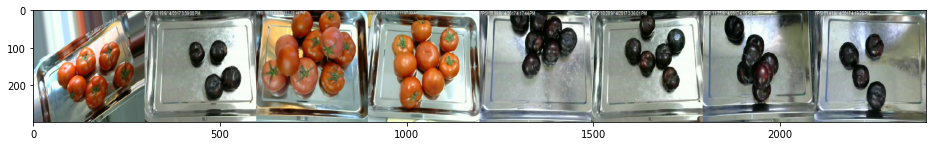

In [16]:
# Exemplo de imagens

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(299, 299)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

In [17]:
# Treinando o modelo

history = new_model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
25/25 [==============================] - 968s 39s/step - loss: 0.2964 - accuracy: 0.8897 - val_loss: 0.0683 - val_accuracy: 0.9940
Epoch 2/10
25/25 [==============================] - 923s 37s/step - loss: 0.0478 - accuracy: 0.9955 - val_loss: 0.0337 - val_accuracy: 0.9970
Epoch 3/10
25/25 [==============================] - 921s 37s/step - loss: 0.0270 - accuracy: 0.9994 - val_loss: 0.0233 - val_accuracy: 0.9985
Epoch 4/10
25/25 [==============================] - 922s 37s/step - loss: 0.0194 - accuracy: 0.9994 - val_loss: 0.0178 - val_accuracy: 1.0000
Epoch 5/10
25/25 [==============================] - 923s 37s/step - loss: 0.0148 - accuracy: 0.9997 - val_loss: 0.0144 - val_accuracy: 1.0000
Epoch 6/10


KeyboardInterrupt: ignored

1/1 [==============================] - 0s 256ms/step
O modelo acha que é uma ameixa
[0. 1.]


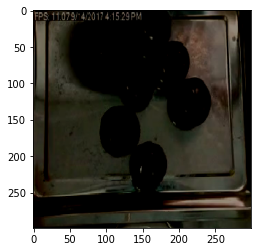

In [45]:
plt.imshow(x_test[4])
pred = np.argmax(new_model.predict(np.expand_dims(x_test[4], axis=0)))

if pred == 0: print('O modelo acha que é um tomate')
if pred == 1: print('O modelo acha que é uma ameixa')
print(y_test[4])

In [46]:
loss, accuracy = new_model.evaluate(x_test, y_test, verbose=0)

In [47]:
accuracy # Acertou 99,4% das vezes

0.9940387606620789

In [50]:
loss

0.017393484711647034